This is the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import celltypist
from celltypist import models

import os


res_name = "pbmc_rep1_sm2"
exp_str = "pbmc1"
method_str = "Smart-seq2"

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

## download celltypist models
# get the low-immune (low-level on ontology, high-resolution)
model_str = 'Immune_All_Low.pkl'
models.download_models(model = [model_str])


📂 Storing models in /beevol/home/davidson/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_Low.pkl (file exists)


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [2]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/GSE132044/sm2_hg19/"

results_file = f"{data_path}/{res_name}.h5ad"

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/beevol-home-davidson-checkouts-sc_bulk_ood-evaluation_experiments-pbmc-..-..-data-single_cell_data-GSE132044-sm2_hg19-matrix.h5ad


In [3]:
# make cell type specific marker annotation

genes_annot_dict = {
    'CD14': ['CD14 (CD14 Mono)'],
    'LYZ': ['LYZ (CD14 Mono)'],
    'FCGR3A': ['FCGR3A (CD16 Mono)'],
    'MS4A7': ['MS4A7 (CD16 Mono)'],
    'FCER1A': ['FCER1A (Dendritic)'],
    'CST3': ['CST3 (Dendritic)'],
    'GNLY': ['GNLY (NK)'],
    'NKG7': ['NKG7 (NK)'],
    'MS4A1': ['MS4A1 (B cell)'],
    'CD79A': ['CD79A (B cell)'],
    'IL7R': ['IL7R (CD4T)'],
    'CCR7': ['CCR7 (Naive CD4T)'],
    'S100A4': ['S100A4 (Memory CD4T)'],
    'CD8A': ['CD8A (CD8 T)'],
    'PPBP': ['PPBP (Megak)']
}



# Initialize empty column in cell metadata
adata.var['gene_annot'] = adata.var_names

# Generate new assignments
for i in genes_annot_dict.keys():
    ind = np.where(pd.Series(adata.var_names).isin([i]))[0]
    adata.var['gene_annot'].iloc[ind] = genes_annot_dict[i]
adata.var['gene_annot'].iloc[ind]

PPBP    PPBP (Megak)
Name: gene_annot, dtype: object

In [4]:
# add metadata
meta_cols = ['code', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method']
barcodes = pd.read_csv(f"{data_path}/barcodes.tsv", header=None, names=['code'])
meta_data = pd.read_csv(f"{data_path}/GSE132044_meta.txt", skiprows=2, names=meta_cols, index_col='code', sep="\t")
meta_df = barcodes.join(other=meta_data, on=['code'], how='left', sort=False)

adata.obs['CellType'] = meta_df['CellType'].tolist()
adata.obs['Experiment'] = meta_df['Experiment'].tolist()
adata.obs['Method'] = meta_df['Method'].tolist()
meta_df

,code,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method
0,pbmc1_SM2_Cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,pbmc1_SM2_Cell_107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,pbmc1_SM2_Cell_108,2200.0,437125.0,0.029743,0.0,Cytotoxic T cell,pbmc1,Smart-seq2
3,pbmc1_SM2_Cell_115,2438.0,335596.0,0.031152,0.0,Cytotoxic T cell,pbmc1,Smart-seq2
4,pbmc1_SM2_Cell_125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
45012,pbmc2_inDrops_1_TAGTCTCT.GAGCCTTA.ATCCGCTA,453.0,717.0,0.097629,11.0,Plasmacytoid dendritic cell,pbmc2,inDrops
45013,pbmc2_inDrops_1_TCCAGAAG.TTATGCGA.TAAGACGG,592.0,938.0,0.035181,11.0,Plasmacytoid dendritic cell,pbmc2,inDrops
45014,pbmc2_inDrops_1_TGAATCCT.GAGCCTTA.CCCAAGCA,406.0,662.0,0.138973,11.0,Plasmacytoid dendritic cell,pbmc2,inDrops
45015,pbmc2_inDrops_1_TGAATCCT.TTATGCGA.CATCTCCC,1001.0,2066.0,0.055663,11.0,Plasmacytoid dendritic cell,pbmc2,inDrops


## Preprocessing

In [5]:
# lets see whats in adata
adata

AnnData object with n_obs × n_vars = 45017 × 33694
    obs: 'CellType', 'Experiment', 'Method'
    var: 'gene_ids', 'gene_annot'

In [6]:
# filter it for only our method and experiment
adata = adata[adata.obs["Experiment"] == exp_str, :]
adata = adata[adata.obs["Method"] == method_str, :]

adata

View of AnnData object with n_obs × n_vars = 253 × 33694
    obs: 'CellType', 'Experiment', 'Method'
    var: 'gene_ids', 'gene_annot'

normalizing counts per cell
    finished (0:00:00)


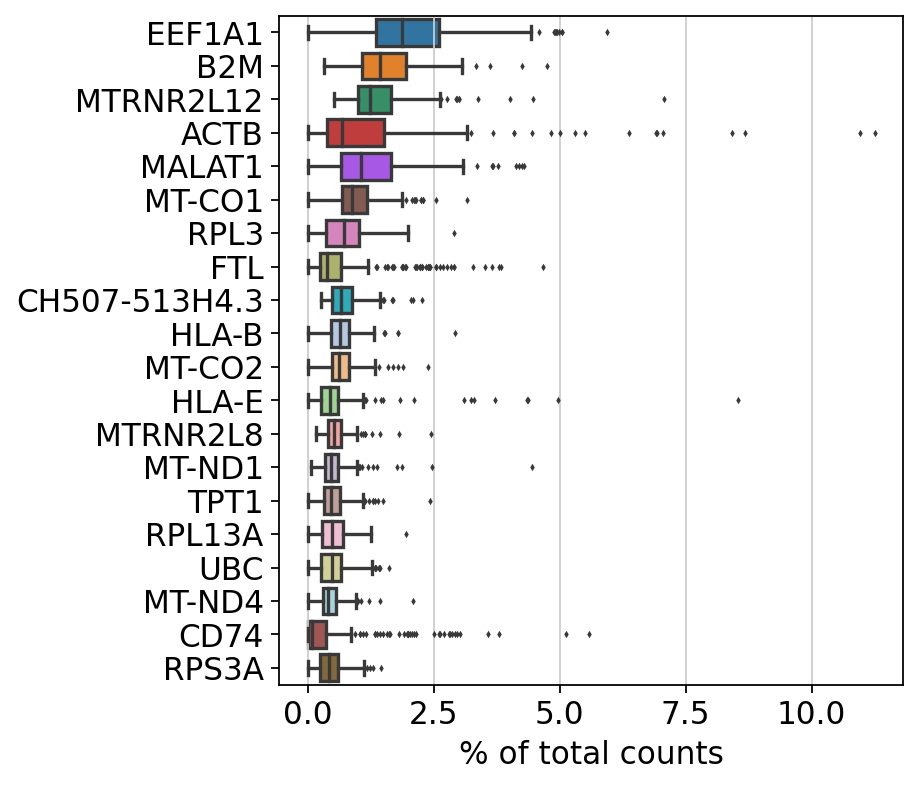

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [8]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=1)

filtered out 10 cells that have less than 500 genes expressed
filtered out 11069 genes that are detected in less than 1 cells


... storing 'CellType' as categorical
... storing 'Experiment' as categorical
... storing 'Method' as categorical


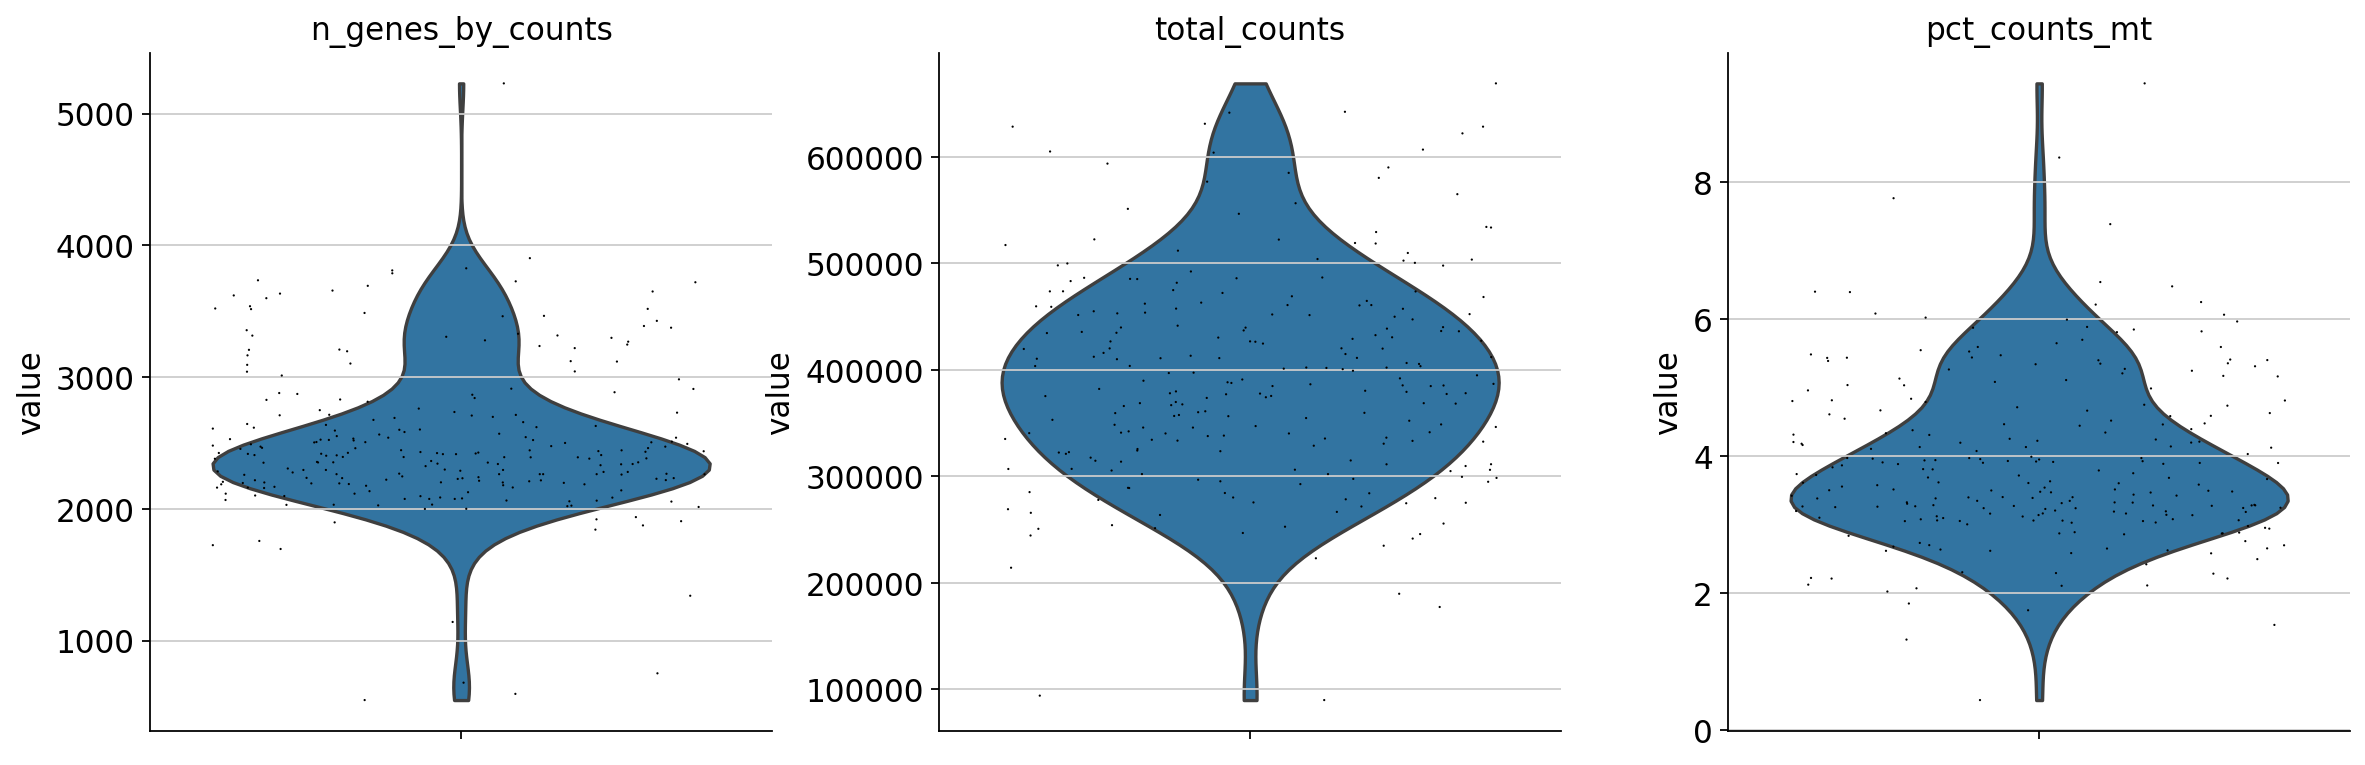

In [9]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

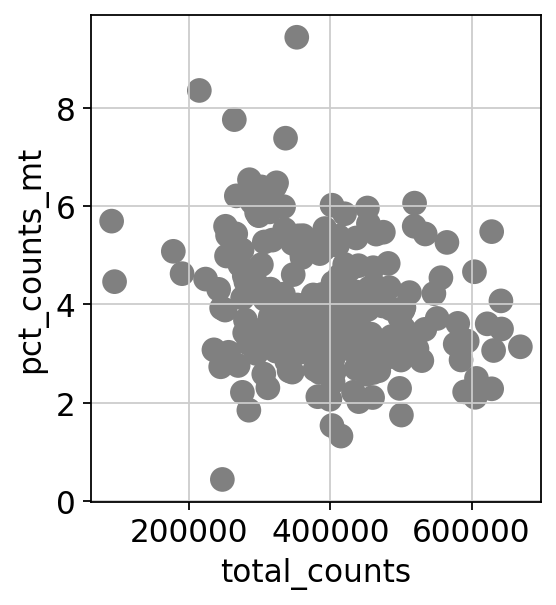

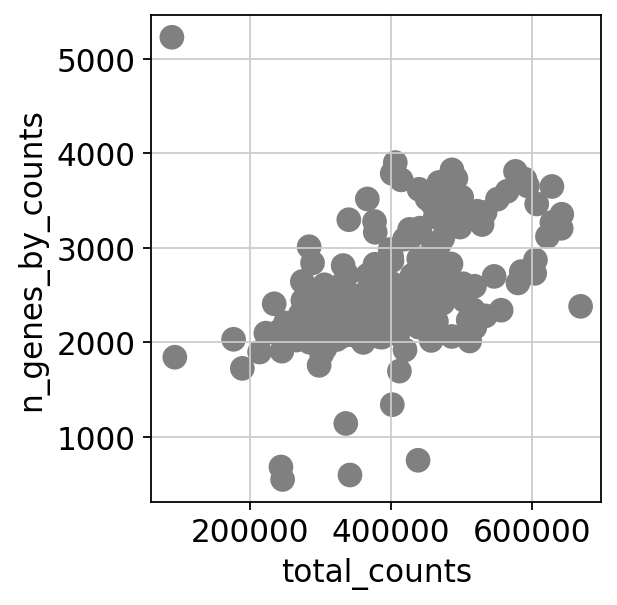

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 7, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


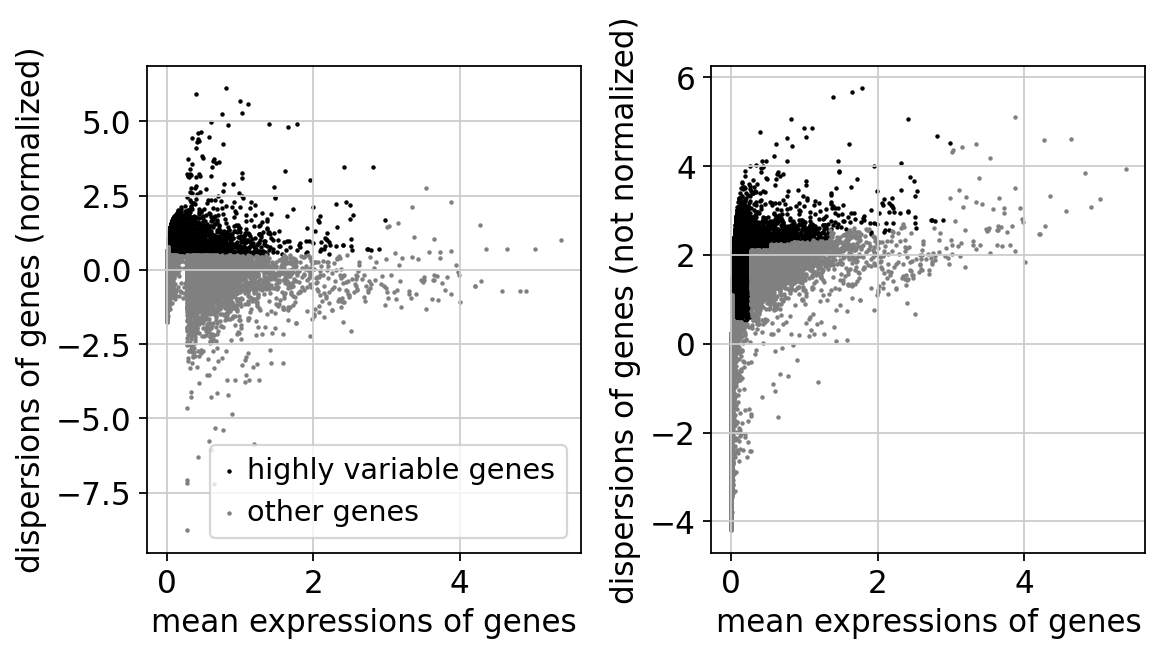

In [12]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
adata.raw = adata
adata.write(results_file)



### Run celltypist

In [13]:
celltype_pred = celltypist.annotate(adata, model = model_str, majority_voting = True)

🔬 Input data has 238 cells and 22625 genes
🔗 Matching reference genes in the model
🧬 1990 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 36 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [14]:
celltype_pred.predicted_labels['majority_voting'].value_counts()

T cells                           87
B cells                           57
Classical monocytes               32
CD16+ NK cells                    26
Tem/Effector cytotoxic T cells     9
NKT cells                          8
Non-classical monocytes            8
pDC                                5
Megakaryocytes/platelets           4
MAIT cells                         2
Name: majority_voting, dtype: int64

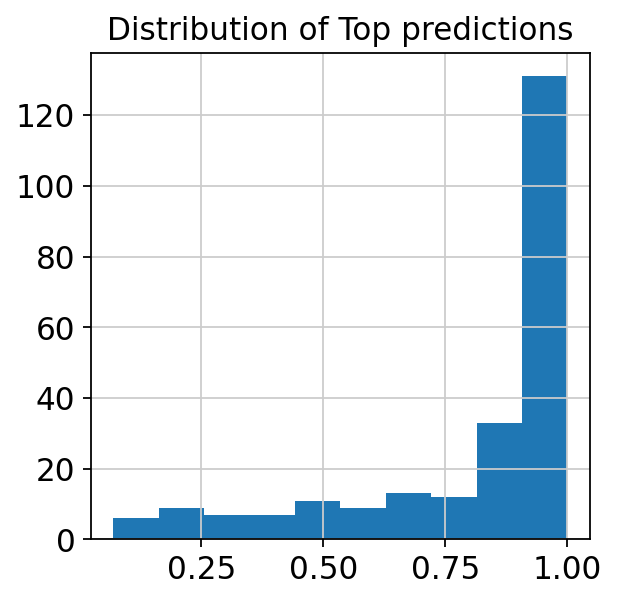

In [15]:
from matplotlib import pyplot as plt 
import numpy as np  

maxValues = celltype_pred.probability_matrix.max(axis = 1)
hist, bins = np.histogram(maxValues)
plt.hist(maxValues, bins = bins) 
plt.title("Distribution of Top predictions") 
plt.show()

In [16]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = celltype_pred.to_adata()
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:30)


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


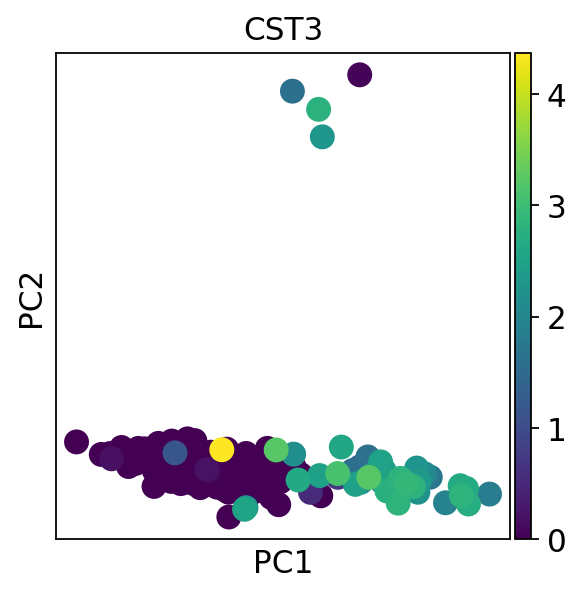

In [17]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')


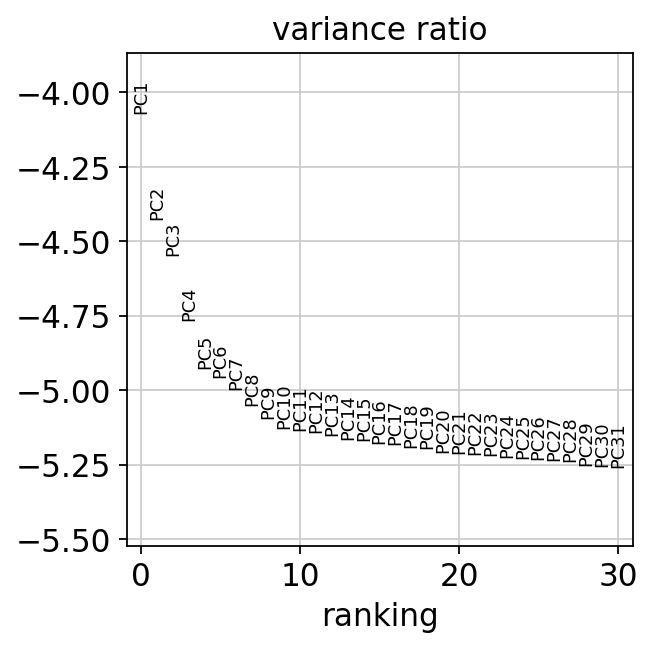

In [18]:
sc.pl.pca_variance_ratio(adata, log=True)


In [19]:
# save results
adata.write(results_file)


## Compute and embed neighborhood graph

In [20]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


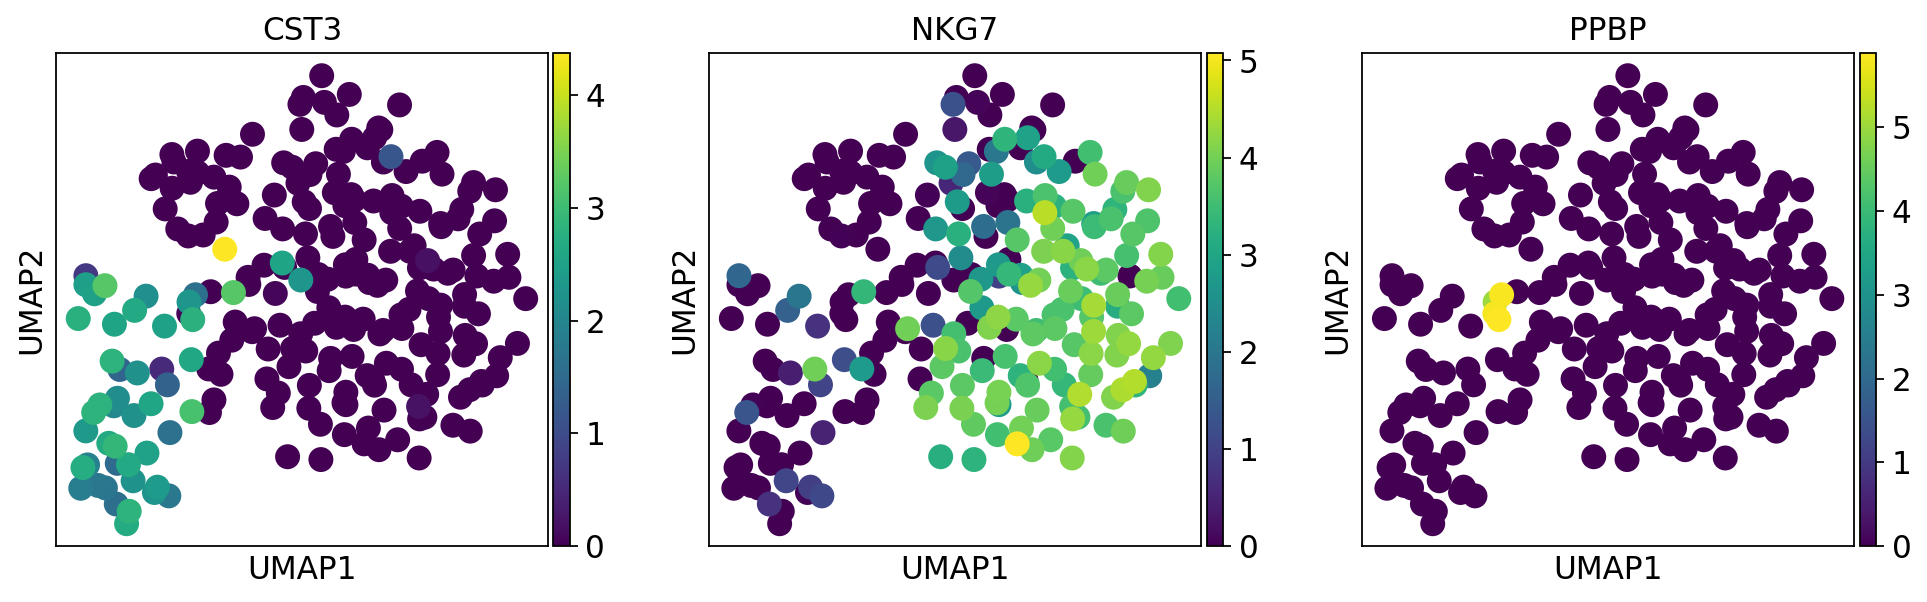

In [21]:
# plot some markers of the RAW data
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])


## Cluster the neighborhood graph

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


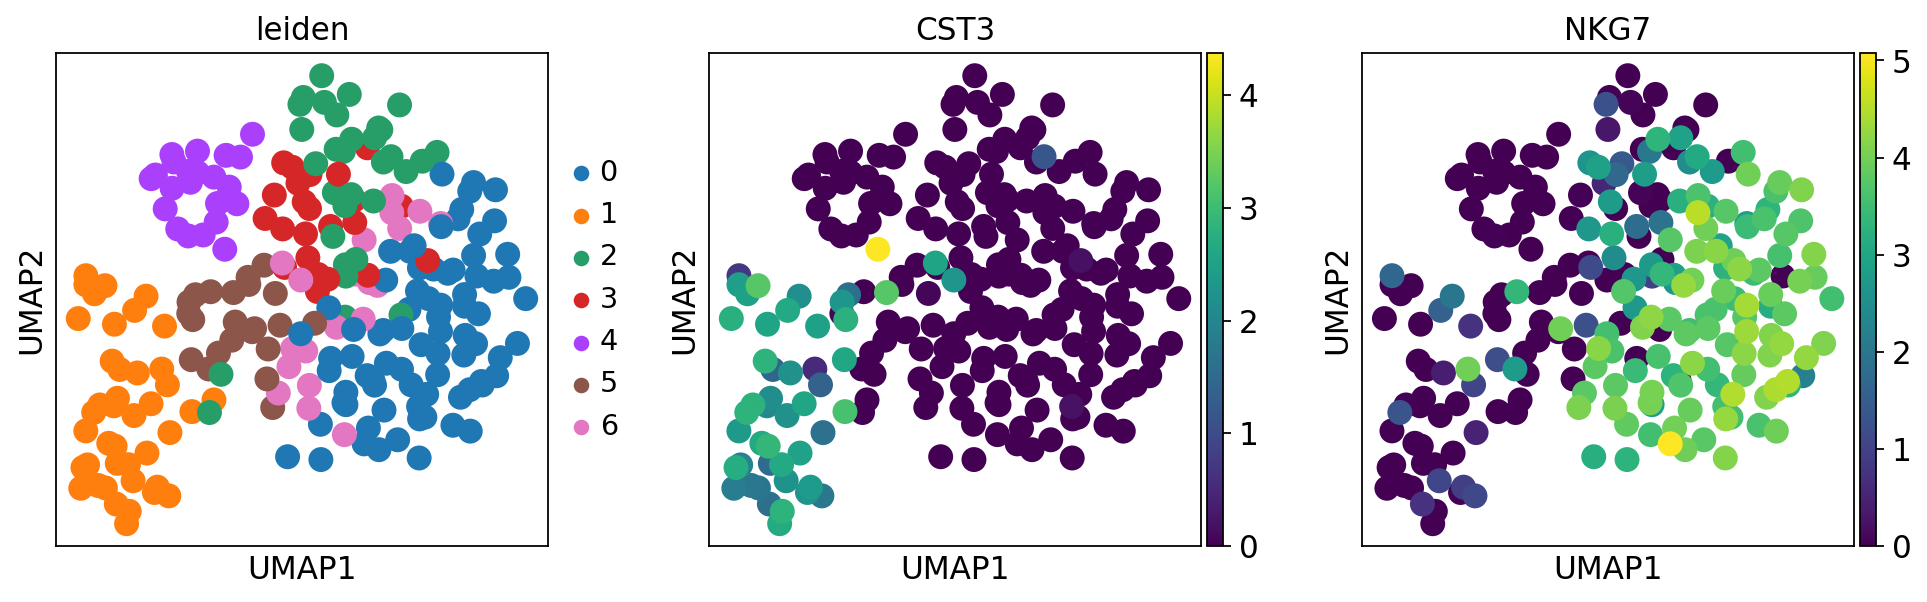

In [22]:
# lets use Leiden clustering
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

# save
adata.write(results_file)


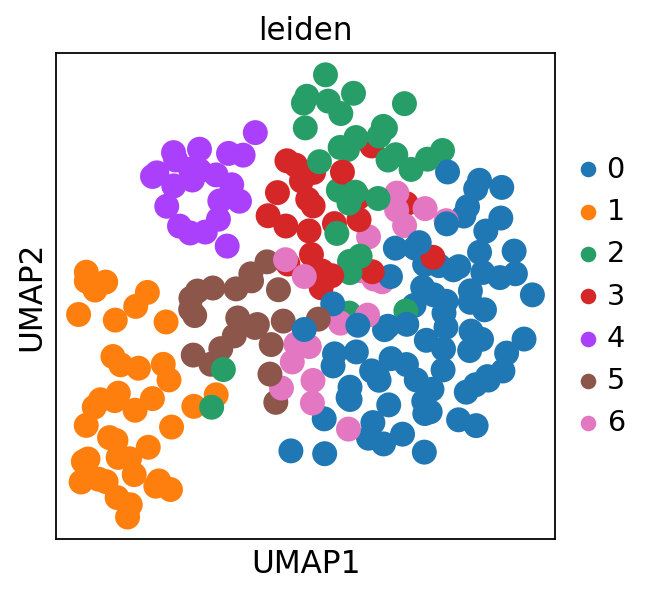

In [23]:
sc.pl.umap(adata, color=['leiden'])


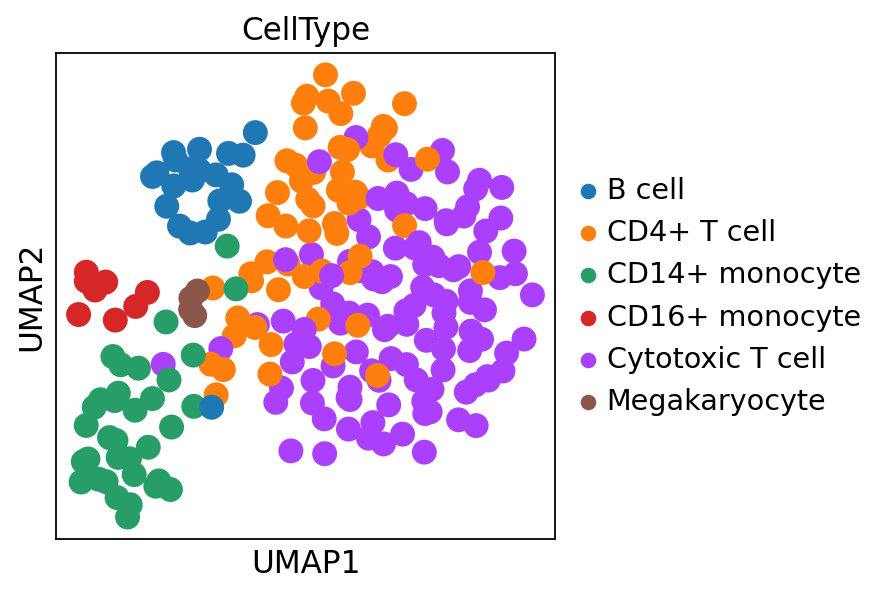

In [24]:

sc.pl.umap(adata, color=['CellType'])


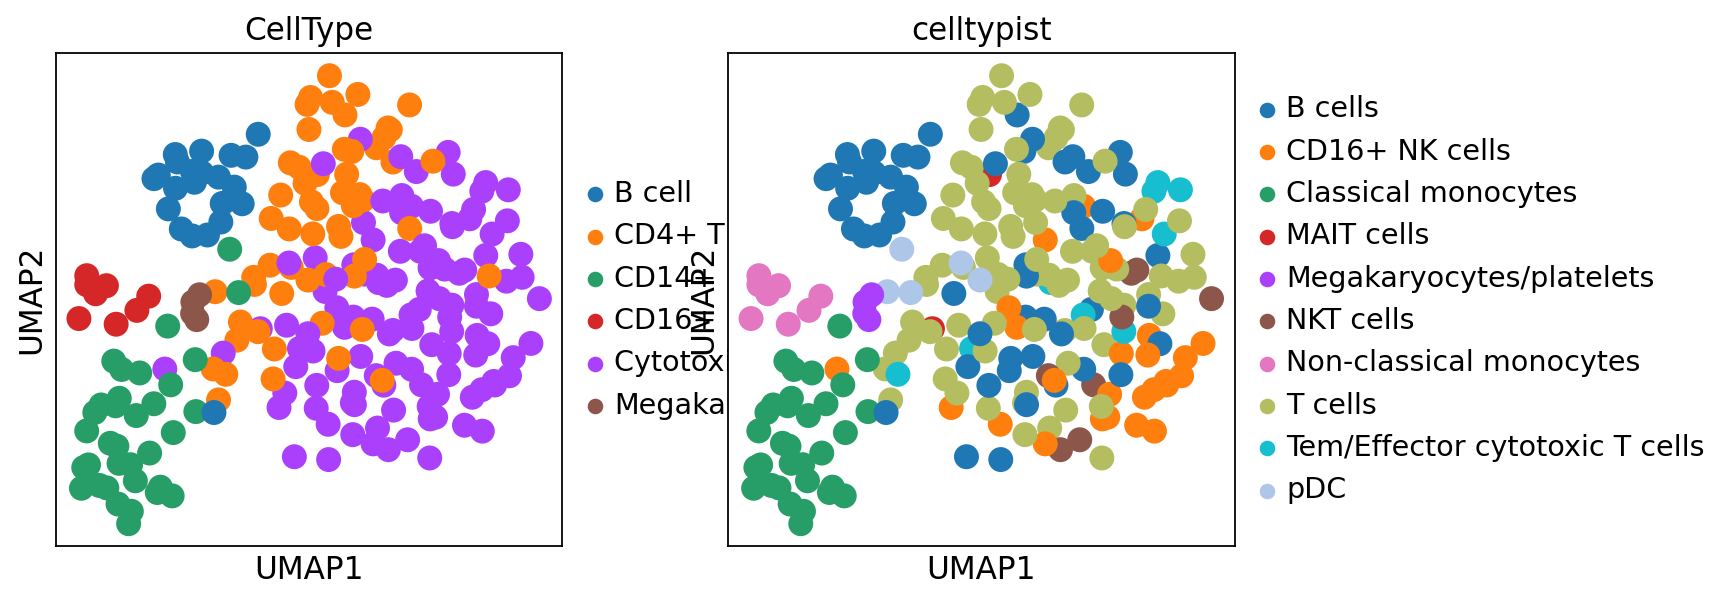

In [25]:
adata.obs['celltypist'] = celltype_pred.predicted_labels['majority_voting']
sc.pl.umap(adata, color=['CellType', 'celltypist'])



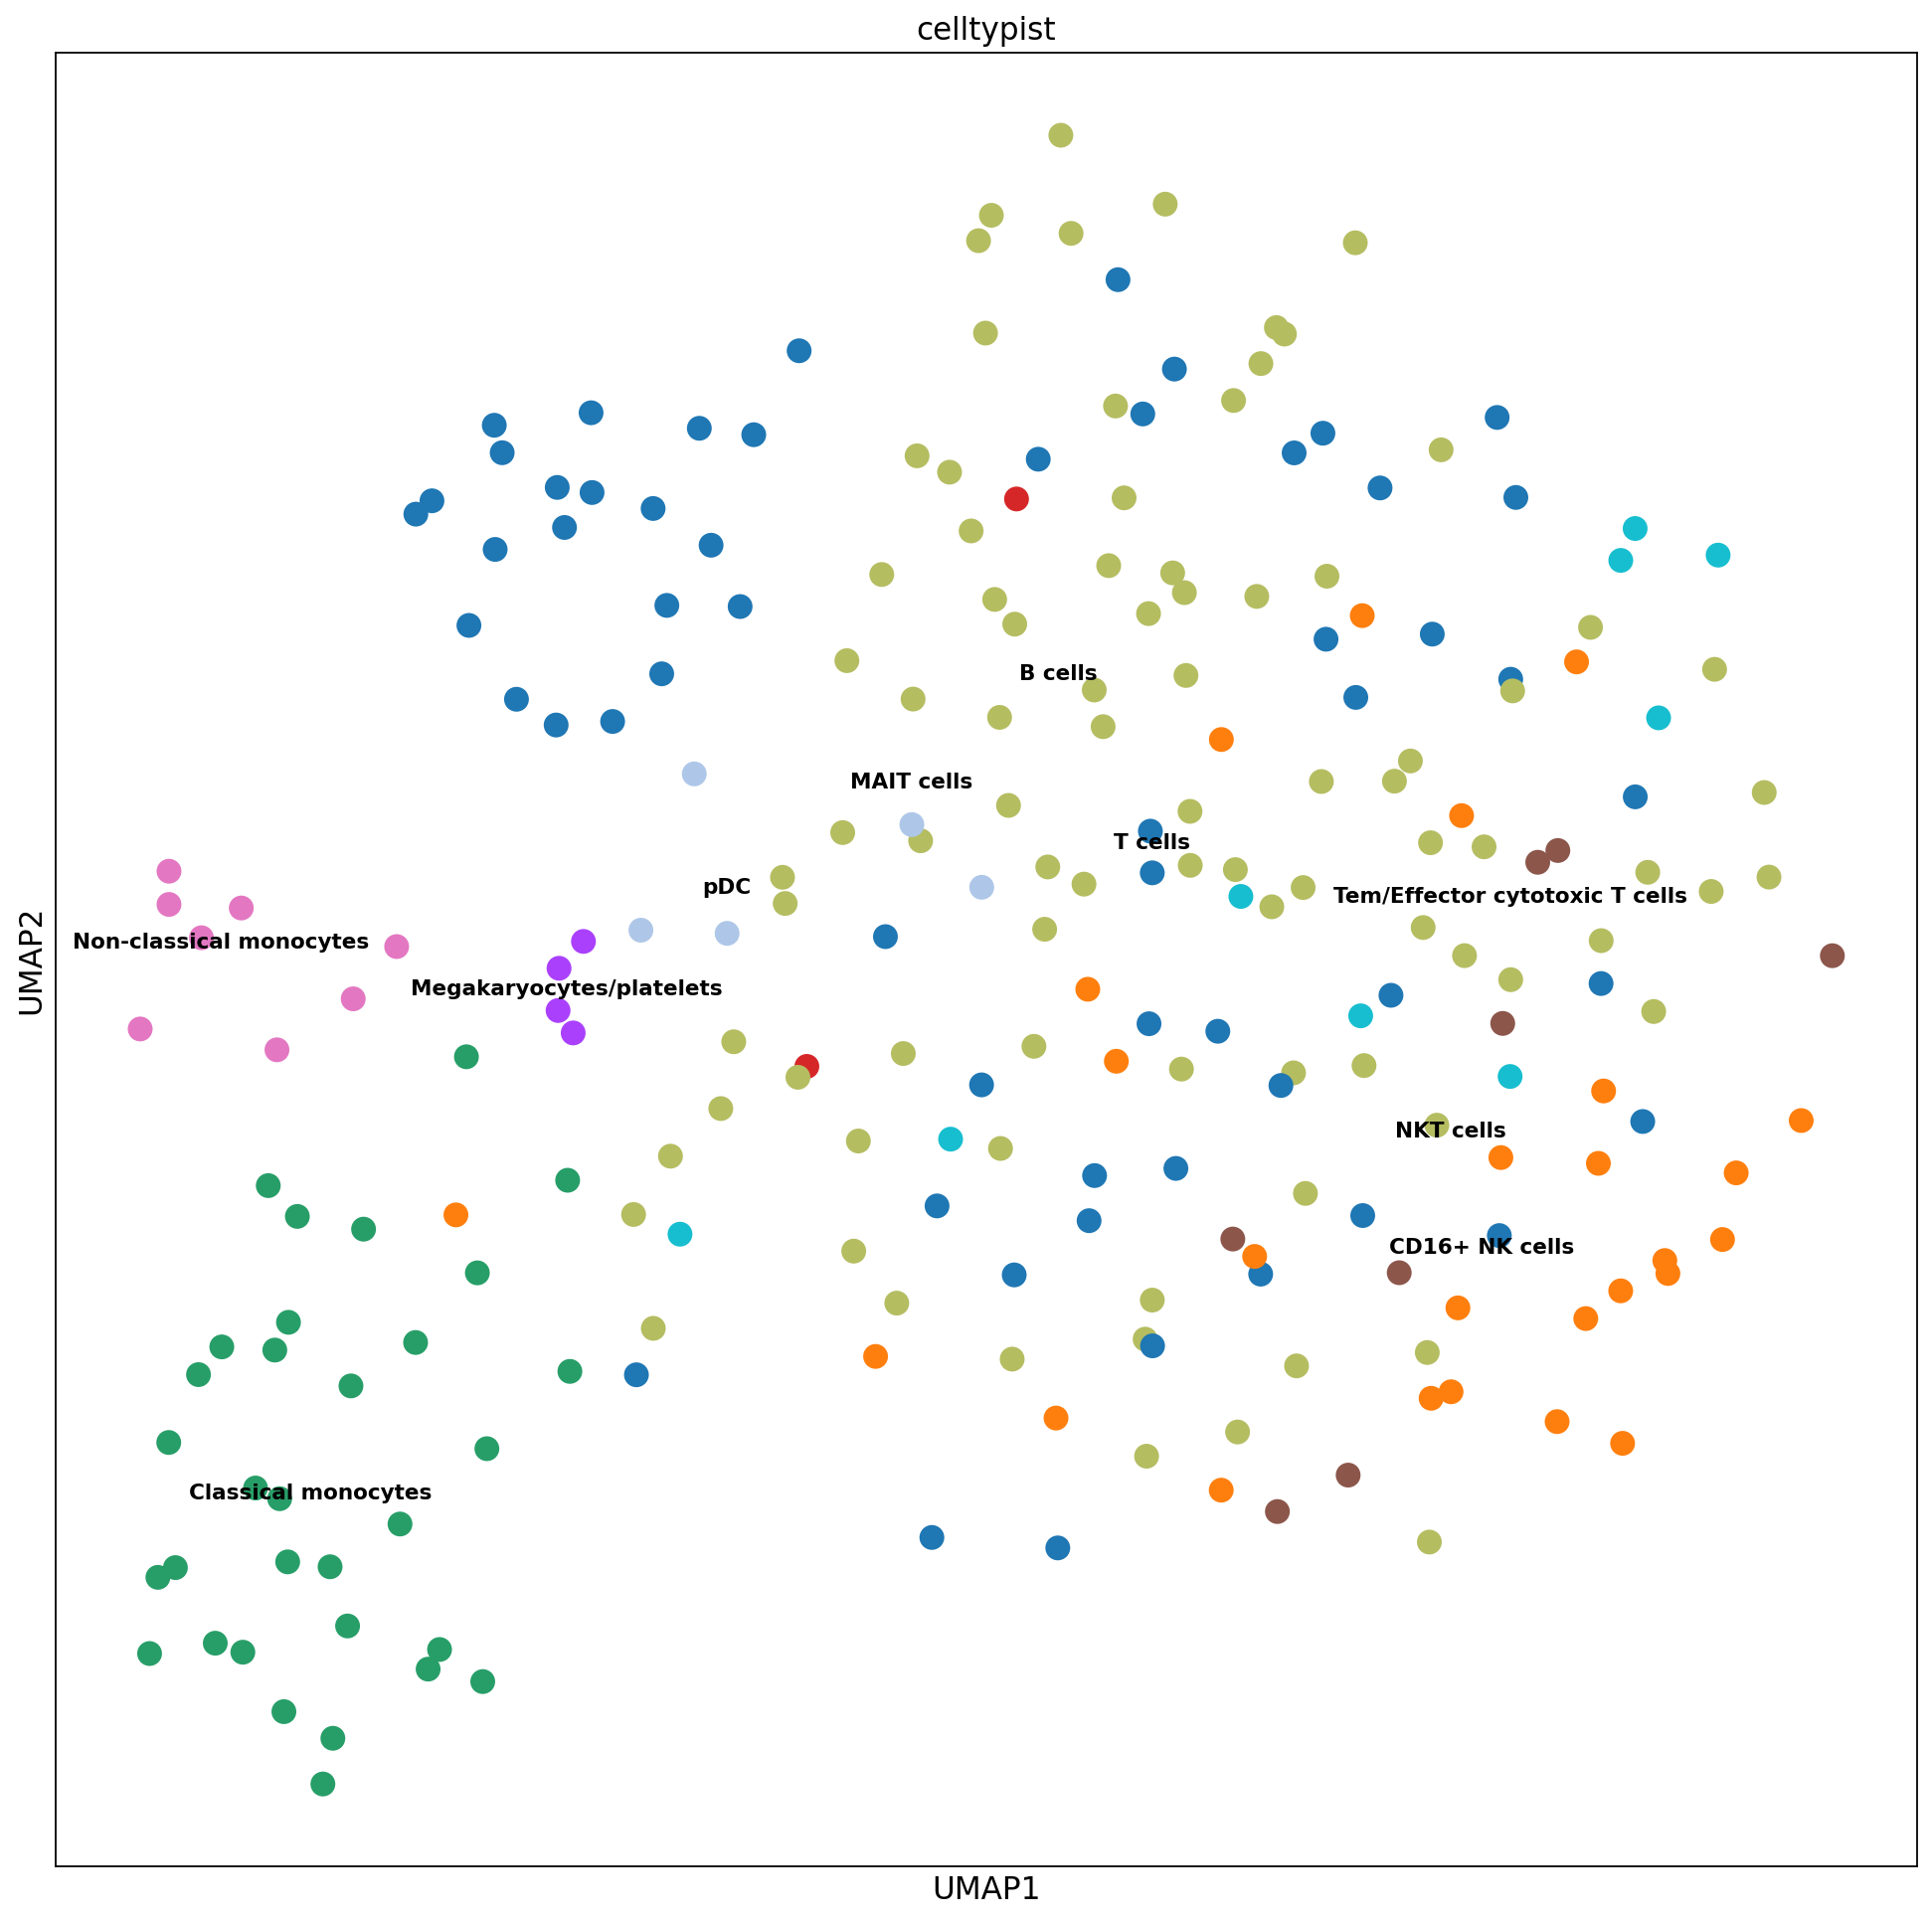

In [26]:
plt.rcParams['figure.figsize'] = [15, 15]
sc.pl.umap(adata, color=['celltypist'], legend_loc='on data', legend_fontsize="x-small")


In [27]:
compare_ct = adata.obs[['celltypist', 'CellType']].groupby(['celltypist', 'CellType'])
compare_ct = compare_ct.size()
compare_ct.unstack()

CellType,B cell,CD4+ T cell,CD14+ monocyte,CD16+ monocyte,Cytotoxic T cell,Megakaryocyte
celltypist,,,,,,
B cells,22,7,0,0,28,0
CD16+ NK cells,0,1,0,0,25,0
Classical monocytes,0,0,32,0,0,0
MAIT cells,0,1,0,0,1,0
Megakaryocytes/platelets,0,0,0,0,0,4
NKT cells,0,0,0,0,8,0
Non-classical monocytes,0,0,0,8,0,0
T cells,0,45,0,0,42,0
Tem/Effector cytotoxic T cells,0,1,0,0,8,0
